## Work
1. 請比較 SGD optimizer 不同的 momentum 及使用 nesterov 與否的表現

In [1]:
import os
import keras

# 本作業可以不需使用 GPU, 將 GPU 設定為 "無" (若想使用可自行開啟)
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 4s 0us/step


In [0]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [0]:
x_train, y_train = train
x_test, y_test = test

# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [0]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, activation='relu', name='hidden_layer'+str(i+1))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, activation='relu', name='hidden_layer'+str(i+1))(x)
            
    output = keras.layers.Dense(units=output_units, activation='softmax', name='output_layer')(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[output])
    return model

In [0]:
# 超參數設定
LEARNING_RATE = 0.01
MOMENTUM = [0.001, 0.01, 0.1, 0.5, 0.95]
EPOCHS = 50
BATCH_SIZE = 256

In [10]:
# nesterov=True
results = {}
for m in MOMENTUM:
    keras.backend.clear_session()
    print('Experiment with MOMENTUM = %.6f' % (m))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=m)
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)
    
    model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_test, y_test), shuffle=True)
    
    # store results for each round
    train_loss = model.history.history['loss']
    valid_loss = model.history.history['val_loss']
    train_acc = model.history.history['acc']
    valid_acc = model.history.history['val_acc']
    
    exp_name_tag = 'exp-m-%s' % str(m)
    results[exp_name_tag] = {'train_loss': train_loss,
                             'valid_loss': valid_loss,
                             'train_acc': train_acc,
                             'valid_acc': valid_acc}


W0723 18:18:10.830859 140383032027008 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0723 18:18:10.924540 140383032027008 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



Experiment with MOMENTUM = 0.001000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output_layer (Dense)         (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________


W0723 18:18:11.094138 140383032027008 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 13s 270us/step - loss: 2.0740 - acc: 0.2616 - val_loss: 1.9533 - val_acc: 0.2979
Epoch 2/50
50000/50000 [==============================] - 13s 263us/step - loss: 1.8933 - acc: 0.3298 - val_loss: 1.8999 - val_acc: 0.3165
Epoch 3/50
50000/50000 [==============================] - 13s 270us/step - loss: 1.8248 - acc: 0.3565 - val_loss: 1.8262 - val_acc: 0.3603
Epoch 4/50
50000/50000 [==============================] - 13s 266us/step - loss: 1.7736 - acc: 0.3763 - val_loss: 1.7895 - val_acc: 0.3674
Epoch 5/50
50000/50000 [==============================] - 13s 269us/step - loss: 1.7364 - acc: 0.3902 - val_loss: 1.7494 - val_acc: 0.3790
Epoch 6/50
50000/50000 [==============================] - 14s 270us/step - loss: 1.7081 - acc: 0.4004 - val_loss: 1.6955 - val_acc: 0.4054
Epoch 7/50
50000/50000 [==============================] - 14s 273us/step - loss: 1.6771 - acc: 0.4111 - val_loss: 1.

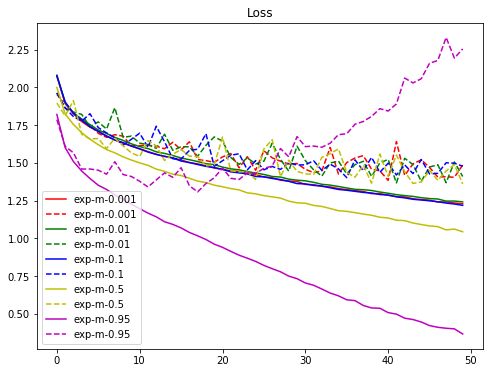

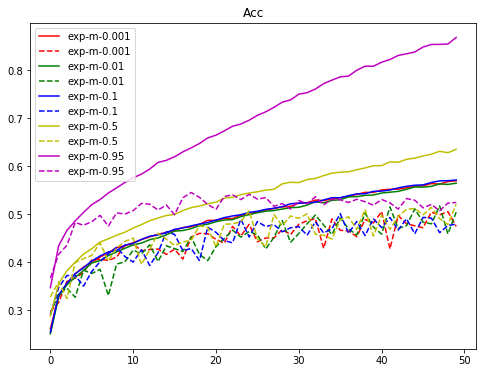

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
colors = ['r', 'g', 'b', 'y', 'm', 'k']

plt.figure(figsize=(8,6))
for i, tag in enumerate(results.keys()):
    plt.plot(range(len(results[tag]['train_loss'])), results[tag]['train_loss'], '-', label=tag, color=colors[i])
    plt.plot(range(len(results[tag]['valid_loss'])), results[tag]['valid_loss'], '--', label=tag, color=colors[i])
plt.title('Loss')
plt.legend()
plt.show()


plt.figure(figsize=(8,6))
for i, tag in enumerate(results.keys()):
    plt.plot(range(len(results[tag]['train_acc'])), results[tag]['train_acc'], '-', label=tag, color=colors[i])
    plt.plot(range(len(results[tag]['valid_acc'])), results[tag]['valid_acc'], '--', label=tag, color=colors[i])
plt.title('Acc')
plt.legend()
plt.show()